<a href="https://colab.research.google.com/github/punithraj25/Hello_World/blob/main/Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [23]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('ML with PySpark') \
                    .getOrCreate()
# What version of Spark?
print(spark.version)

3.5.0


In [24]:
flights_df = spark.read.csv('/flights-larger.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

In [25]:
# Check column data types
print(flights_df.dtypes)

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


In [26]:
# Remove the 'flight' column
flights_df =  flights_df.drop('flight')

# Remove records with missing 'delay' values
#flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# Remove records with missing values
flights_df = flights_df.dropna()
print(flights_df.count())

258289


In [27]:
# Convert columns 'mile' to 'km' and then drop it
flights_km = flights_df.withColumn('km', round(flights_df.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether a flight is delayed or not
flights_km = flights_km.withColumn('label', (flights_km.delay >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



In [28]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|        2.0|    0.0|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|        2.0|    0.0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|        4.0|    2.0|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|        3.0|    5.0|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|        4.0|    3.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
only showing top 5 rows



In [29]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')
# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)
# Check the resulting column
flights_assembled.select('features', 'delay').show(5, truncate=False)

+-----------------------------------------+-----+
|features                                 |delay|
+-----------------------------------------+-----+
|[10.0,10.0,1.0,2.0,0.0,253.0,8.18,51.0]  |27   |
|[11.0,22.0,1.0,2.0,0.0,1188.0,7.17,127.0]|-19  |
|[2.0,14.0,5.0,4.0,2.0,3618.0,21.17,365.0]|60   |
|[5.0,25.0,3.0,3.0,5.0,621.0,12.92,85.0]  |22   |
|[3.0,28.0,1.0,4.0,3.0,1732.0,13.33,182.0]|70   |
+-----------------------------------------+-----+
only showing top 5 rows



In [30]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights_assembled.count()
print(training_ratio)

0.7997359546864171


In [31]:
# Create a DT classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)
# Create predictions on test data
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.37010716886900424,0.6298928311309957]|
|1    |1.0       |[0.37010716886900424,0.6298928311309957]|
|0    |1.0       |[0.37010716886900424,0.6298928311309957]|
|0    |1.0       |[0.37010716886900424,0.6298928311309957]|
|0    |1.0       |[0.37010716886900424,0.6298928311309957]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [32]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 7712|
|    0|       0.0|14756|
|    1|       1.0|18181|
|    0|       1.0|11077|
+-----+----------+-----+

0.6367590766732397


In [33]:
# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 0.62
recall    = 0.70


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [39]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(labels, probabilities)

In [44]:
# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)
# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9378|
|    0|       0.0|15026|
|    1|       1.0|16515|
|    0|       1.0|10807|
+-----+----------+-----+



In [45]:
# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 0.62
recall    = 0.70


In [46]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9378|
|    0|       0.0|15026|
|    1|       1.0|16515|
|    0|       1.0|10807|
+-----+----------+-----+

0.6097707149209295


In [47]:
# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 0.60
recall    = 0.64


In [48]:
import matplotlib.pyplot as plt


In [49]:
# Precision values obtained from your models
decision_tree_precision = 0.85  # Replace with your actual value
logistic_regression_precision = 0.78  # Replace with your actual value

# Model names for the x-axis
models = ['Decision Tree', 'Logistic Regression']

# Precision values for the y-axis
precision_values = [decision_tree_precision, logistic_regression_precision]

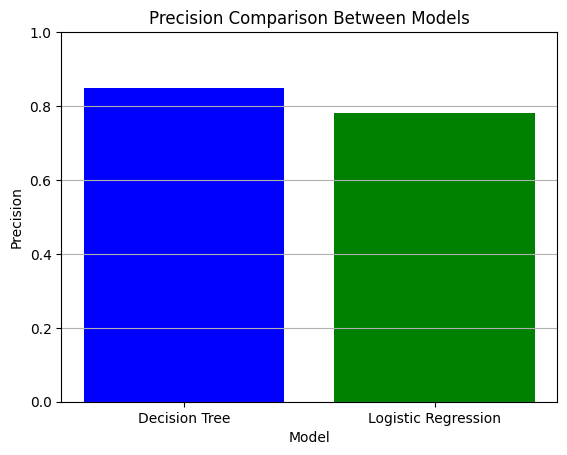

In [50]:
# Create a bar chart
plt.bar(models, precision_values, color=['blue', 'green'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison Between Models')

# Show the plot
plt.ylim(0, 1.0)  # You can adjust the y-axis limits if needed
plt.grid(axis='y')
plt.show()

In [51]:
# Recall values obtained from your models
decision_tree_recall = 0.72  # Replace with your actual value
logistic_regression_recall = 0.65  # Replace with your actual value

# Model names for the x-axis
models = ['Decision Tree', 'Logistic Regression']

# Recall values for the y-axis
recall_values = [decision_tree_recall, logistic_regression_recall]

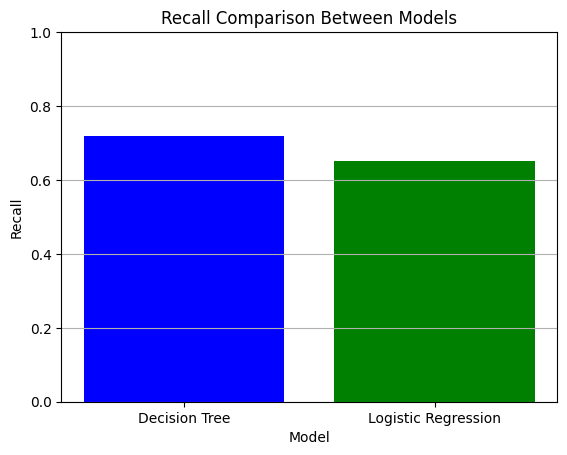

In [52]:
# Create a bar chart
plt.bar(models, recall_values, color=['blue', 'green'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparison Between Models')

# Show the plot
plt.ylim(0, 1.0)  # You can adjust the y-axis limits if needed
plt.grid(axis='y')
plt.show()